In [1]:
import sys
sys.path.insert(1, '/home/599/dbi599/xks/')
sys.path.insert(1, '../unseen')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dask.distributed import Client, LocalCluster
from scipy.stats import genextreme as gev
from scipy.stats import percentileofscore

import fileio
import xks

Matplotlib is building the font cache; this may take a moment.


In [2]:
cluster = LocalCluster()
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:33469 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [2]:
seatac_file = '/g/data/xv83/dbi599/ag/tasmax_seatac.nc'

In [3]:
ds_seatac = fileio.open_file(seatac_file,
                             metadata_file='../config/dataset_knmi_daily.yml',
                             time_freq='A-DEC',
                             time_agg='max')

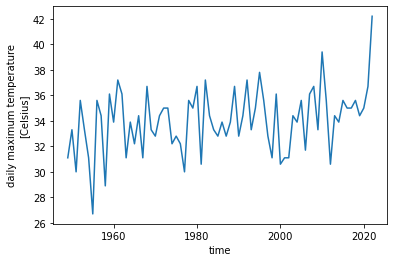

In [4]:
ds_seatac['tasmax'].plot()
plt.show()

In [5]:
cafe_file = '/g/data/xv83/dbi599/ag/tasmax_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-max_seatac.zarr.zip'

ds_cafe = fileio.open_file(cafe_file)

In [6]:
ds_cafe

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 62, lead_time: 9)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8
    time       (lead_time, init_date) object dask.array<chunksize=(9, 62), meta=np.ndarray>
Data variables:
    tasmax     (init_date, lead_time, ensemble) float32 dask.array<chunksize=(1, 9, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Aug 11 12:56:49 2021: /g/data/e14/dbi599/miniconda3/envs/...
    title:      AccessOcean-AM2

In [7]:
ds_cafe_stacked = ds_cafe.stack({'sample': ['ensemble', 'init_date', 'lead_time']}).compute()

In [8]:
ds_cafe_stacked

<xarray.Dataset>
Dimensions:    (sample: 53568)
Coordinates:
    time       (sample) object 1991-05-01 00:00:00 ... 2029-11-01 00:00:00
  * sample     (sample) MultiIndex
  - ensemble   (sample) int64 1 1 1 1 1 1 1 1 1 1 ... 96 96 96 96 96 96 96 96 96
  - init_date  (sample) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
  - lead_time  (sample) int64 0 1 2 3 4 5 6 7 8 0 1 2 ... 7 8 0 1 2 3 4 5 6 7 8
Data variables:
    tasmax     (sample) float32 28.8 36.74 27.87 33.88 ... 33.17 38.9 30.19
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Aug 11 12:56:49 2021: /g/data/e14/dbi599/miniconda3/envs/...
    title:      AccessOcean-AM2

In [9]:
# shape, location (mean), scale (stdev)
model_gev_shape, model_gev_loc, model_gev_scale = gev.fit(ds_cafe_stacked['tasmax'].values)
print(model_gev_shape, model_gev_loc, model_gev_scale)

0.2535532351612009 32.036434374768916 3.6349083191114673


In [10]:
obs_gev_shape, obs_gev_loc, obs_gev_scale = gev.fit(ds_seatac['tasmax'].values)
print(obs_gev_shape, obs_gev_loc, obs_gev_scale)

0.21675703598568266 33.062582009420225 2.505637559246086


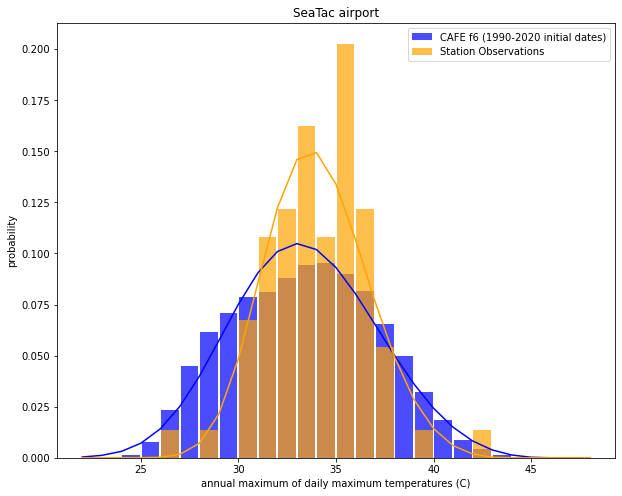

In [11]:
fig = plt.figure(figsize=[10, 8])

ds_cafe_stacked['tasmax'].plot.hist(bins=np.arange(23, 49),
                                    density=True,
                                    rwidth=0.9,
                                    alpha=0.7,
                                    color='blue',
                                    label='CAFE f6 (1990-2020 initial dates)')

xvals = np.arange(22, 49)
model_gev_pdf = gev.pdf(xvals, model_gev_shape, model_gev_loc, model_gev_scale)
plt.plot(xvals, model_gev_pdf, color='blue')

ds_seatac['tasmax'].plot.hist(bins=np.arange(23, 49),
                              density=True,
                              rwidth=0.9,
                              alpha=0.7,
                              color='orange',
                              label='Station Observations')

obs_gev_pdf = gev.pdf(xvals, obs_gev_shape, obs_gev_loc, obs_gev_scale)
plt.plot(xvals, obs_gev_pdf, color='orange')

plt.legend()
plt.xlabel('annual maximum of daily maximum temperatures (C)')
plt.ylabel('probability')
plt.title('SeaTac airport')
#plt.ylim(0, 0.006)
#plt.xlim(42, 48)
plt.savefig(f'/g/data/xv83/dbi599/seatac/tasmax_histogram_seatac.pdf', bbox_inches='tight', facecolor='white')
plt.show()

In [12]:
maximum = float(ds_cafe_stacked['tasmax'].max().values)
maximum

46.101165771484375

In [13]:
percentileofscore(ds_cafe_stacked['tasmax'].values, 42.2)

99.47356630824373

In [14]:
(ds_cafe_stacked['tasmax'].values > 42.2).sum()

282

In [12]:
population_size = 62 * 9 * 96
n_repeats = 1000

df_random = pd.DataFrame([maximum]*n_repeats, columns=[population_size])
      
for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
    estimates = []
    for resample in range(n_repeats):
        random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
        random_indexes.sort()
        tasmax_max = float(ds_cafe_stacked['tasmax'].isel({'sample': random_indexes}).max().values)
        estimates.append(tasmax_max)
    df_random[sample_size] = estimates

df_random = df_random.reindex(sorted(df_random.columns), axis=1)

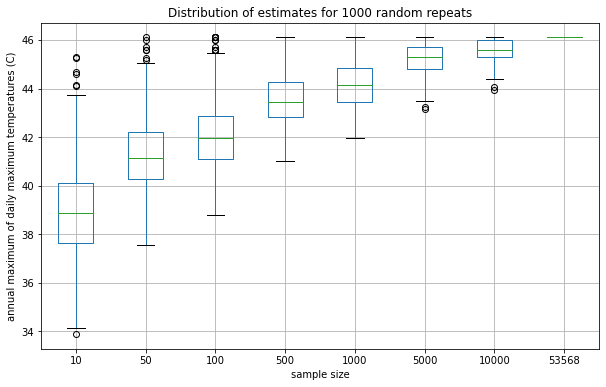

In [13]:
fig = plt.figure(figsize=[10, 6])
df_random.boxplot()
plt.title('Distribution of estimates for 1000 random repeats')
plt.xlabel('sample size')
plt.ylabel('annual maximum of daily maximum temperatures (C)')
plt.savefig(f'/g/data/xv83/dbi599/seatac/tasmax_samples_seatac.pdf', bbox_inches='tight', facecolor='white')
#plt.show()

The degrees of freedom in my plot reduces as the sample size increases because it's not an infinite sample like the toy example. To check whether that matters much I could fit a GEV to the model data, sample from that, and then overlay the corresponding box and whisker plot on the one above. They look pretty similar...

In [36]:
gev_dict = {}
n_repeats = 1000
for sample_size in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    estimates = []
    for resample in range(n_repeats):
        tasmax_max = gev.rvs(gev_shape, loc=gev_loc, scale=gev_scale, size=sample_size).max()
        estimates.append(tasmax_max)
    gev_dict[sample_size] = estimates

df_gev = pd.DataFrame(gev_dict)
df_gev = df_gev.reindex(sorted(df_gev.columns), axis=1)

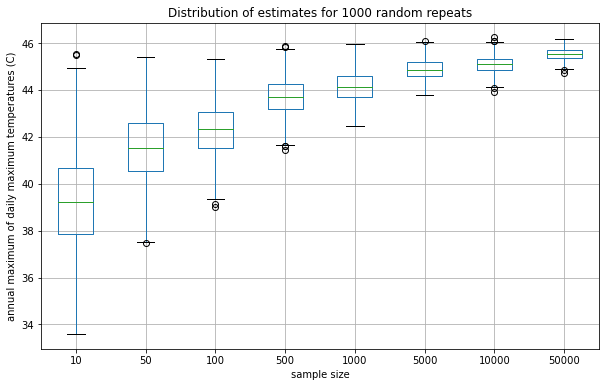

In [39]:
fig = plt.figure(figsize=[10, 6])
df_gev.boxplot()
plt.title('Distribution of estimates for 1000 random repeats')
plt.xlabel('sample size')
plt.ylabel('annual maximum of daily maximum temperatures (C)')
plt.show()

In [13]:
population_size = 62 * 9 * 96
n_repeats = 1000

maximum = float(ds_cafe_stacked['tasmax'].max().values)
df_model = pd.DataFrame([maximum]*n_repeats, columns=[population_size])

gev_shape, gev_loc, gev_scale = gev.fit(ds_cafe_stacked['tasmax'].values)
gev_max = gev.rvs(gev_shape, loc=gev_loc, scale=gev_scale, size=population_size).max()
df_gev = pd.DataFrame([gev_max]*n_repeats, columns=[population_size])

for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
    print(sample_size)
    model_estimates = []
    gev_estimates = []
    for resample in range(n_repeats):
        random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
        random_indexes.sort()
        model_subsample = ds_cafe_stacked['tasmax'].isel({'sample': random_indexes})
        model_max = float(model_subsample.max().values)
        model_estimates.append(model_max)
        gev_shape, gev_loc, gev_scale = gev.fit(model_subsample.values)
        gev_max = gev.rvs(gev_shape, loc=gev_loc, scale=gev_scale, size=10000).max()
        gev_estimates.append(gev_max)
    df_model[sample_size] = model_estimates
    df_gev[sample_size] = gev_estimates

df_model = df_model.reindex(sorted(df_model.columns), axis=1)
df_gev = df_gev.reindex(sorted(df_gev.columns), axis=1)

10
50
100
500
1000
5000
10000


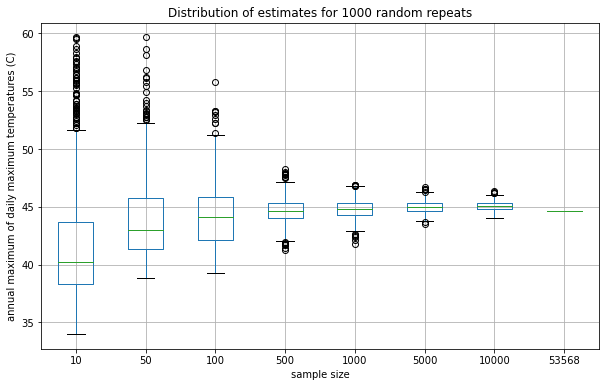

In [47]:
fig = plt.figure(figsize=[10, 6])
df_gev.mask(df_gev > 60).boxplot()
plt.title('Distribution of estimates for 1000 random repeats')
plt.xlabel('sample size')
plt.ylabel('annual maximum of daily maximum temperatures (C)')
plt.show()

The maximum temperature in the SeaTac obs was 42.2C.

TODO: Plot the likelihood of sampling at least one event > some value for different sample sizes, where some value is 40, 42, 44, etc.

TODO: Plot the return value distributions (return value just number of years over a threshold divided by the numberof samples)

Is there a simple test we could define to determine whether your sample is sufficiently large? (e.g. rainfall)


In [15]:
def return_period(data, score):
    """Calculate the return period for a given score"""
    
    n_exceedance_events = (data > score).sum()
    exceedance_probability = n_exceedance_events / len(data)
    
    return 1. / exceedance_probability

In [16]:
population_size = ds_cafe_stacked['tasmax'].shape[0]

full_model_return_period = return_period(ds_cafe_stacked['tasmax'].values, 42.2)

gev_shape, gev_loc, gev_scale = gev.fit(ds_cafe_stacked['tasmax'].values)
gev_data = gev.rvs(gev_shape, loc=gev_loc, scale=gev_scale, size=population_size)
full_gev_return_period = return_period(gev_data, 42.2)

In [17]:
full_model_return_period

189.95744680851064

In [18]:
full_gev_return_period

145.17073170731706

In [27]:
obs_gev_data = gev.rvs(obs_gev_shape, loc=obs_gev_loc, scale=obs_gev_scale, size=population_size)
obs_gev_return_period = return_period(obs_gev_data, 42.2)
obs_gev_return_period

1373.5384615384614

In [28]:
n_repeats = 1000

df_model_return_period = pd.DataFrame([full_model_return_period]*n_repeats, columns=[population_size])
df_gev_return_period = pd.DataFrame([full_gev_return_period]*n_repeats, columns=[population_size])

for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
    print(sample_size)
    model_estimates = []
    gev_estimates = []
    for resample in range(n_repeats):
        random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
        random_indexes.sort()
        model_subsample = ds_cafe_stacked['tasmax'].isel({'sample': random_indexes})
        model_return_period = return_period(model_subsample.values, 42.2)
        model_estimates.append(model_return_period)
        gev_shape, gev_loc, gev_scale = gev.fit(model_subsample.values)
        gev_data = gev.rvs(gev_shape, loc=gev_loc, scale=gev_scale, size=population_size)
        gev_return_period = return_period(gev_data, 42.2)
        gev_estimates.append(gev_return_period)
    df_model_return_period[sample_size] = model_estimates
    df_gev_return_period[sample_size] = gev_estimates

df_model_return_period = df_model_return_period.reindex(sorted(df_model_return_period.columns), axis=1)
df_gev_return_period = df_gev_return_period.reindex(sorted(df_gev_return_period.columns), axis=1)

10
50
100
500
1000
5000
10000


In [29]:
df_model_return_period.replace(np.inf, np.nan, inplace=True)

In [30]:
df_model_return_period

,10,50,100,500,1000,5000,10000,53568
0,NaN,NaN,NaN,125.000000,166.666667,294.117647,153.846154,189.957447
1,NaN,NaN,NaN,500.000000,250.000000,185.185185,227.272727,189.957447
2,NaN,50.0,NaN,125.000000,142.857143,166.666667,163.934426,189.957447
3,NaN,NaN,100.0,100.000000,1000.000000,192.307692,188.679245,189.957447
4,NaN,NaN,NaN,83.333333,333.333333,217.391304,158.730159,189.957447
...,...,...,...,...,...,...,...,...
995,NaN,NaN,50.0,166.666667,166.666667,227.272727,204.081633,189.957447
996,NaN,50.0,50.0,250.000000,500.000000,217.391304,188.679245,189.957447
997,NaN,NaN,NaN,166.666667,200.000000,217.391304,163.934426,189.957447
998,NaN,NaN,NaN,NaN,166.666667,156.250000,294.117647,189.957447


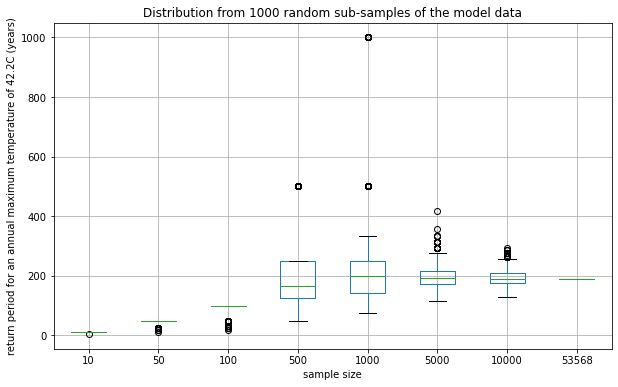

In [31]:
fig = plt.figure(figsize=[10, 6])
df_model_return_period.boxplot()
plt.title('Distribution from 1000 random sub-samples of the model data')
plt.xlabel('sample size')
plt.ylabel('return period for an annual maximum temperature of 42.2C (years)')
plt.savefig(f'/g/data/xv83/dbi599/seatac/model_return_periods_seatac.pdf', bbox_inches='tight', facecolor='white')
plt.show()

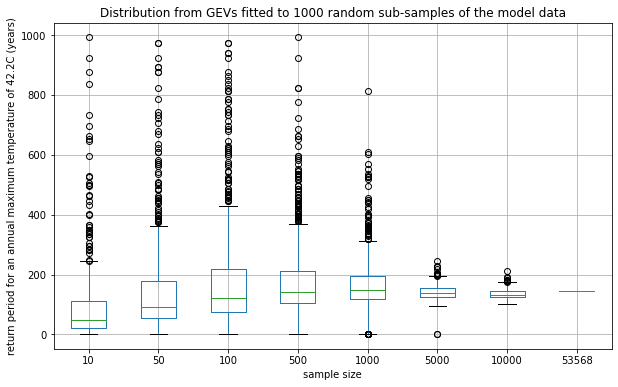

In [32]:
fig = plt.figure(figsize=[10, 6])
df_gev_return_period.mask(df_gev_return_period > 1000).boxplot()
#df_gev_return_period.boxplot()
plt.title('Distribution from GEVs fitted to 1000 random sub-samples of the model data')
plt.xlabel('sample size')
plt.ylabel('return period for an annual maximum temperature of 42.2C (years)')
plt.savefig(f'/g/data/xv83/dbi599/seatac/gev_return_periods_seatac.pdf', bbox_inches='tight', facecolor='white')
plt.show()

In [14]:
def likelihood_curve(threshold):
    """Blah"""
    
    population_size = ds_cafe_stacked['tasmax'].size
    n_repeats = 1000
    sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000, population_size]
    likelihoods = []
    for sample_size in sample_sizes:
        event_count = []
        for resample in range(n_repeats):
            random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
            random_indexes.sort()
            tasmax_max = float(ds_cafe_stacked['tasmax'].isel({'sample': random_indexes}).max().values)
            event_count.append(tasmax_max > threshold)
        n_events = np.sum(event_count)
        likelihood = (n_events / n_repeats) * 100
        likelihoods.append(likelihood)
    
    return likelihoods, sample_sizes

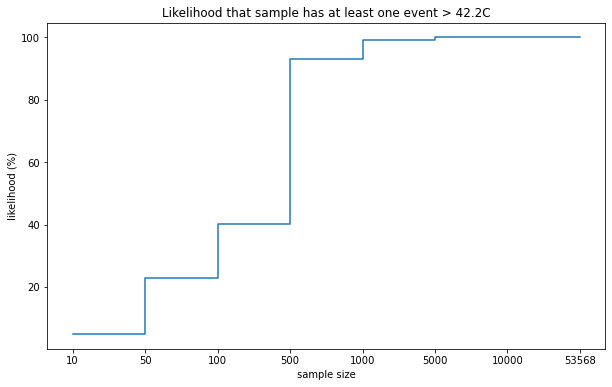

In [15]:
likelihoods, sample_sizes = likelihood_curve(42.2)

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot()

ax.step(np.arange(len(sample_sizes)) + 1, likelihoods, where='post')
ax.set_xticklabels([0] + sample_sizes)
ax.set_ylabel('likelihood (%)')
ax.set_xlabel('sample size')
ax.set_title('Likelihood that sample has at least one event > 42.2C')
plt.savefig(f'/g/data/xv83/dbi599/tasmax_likelihoods-42C_seatac.pdf', bbox_inches='tight', facecolor='white')
#plt.show()

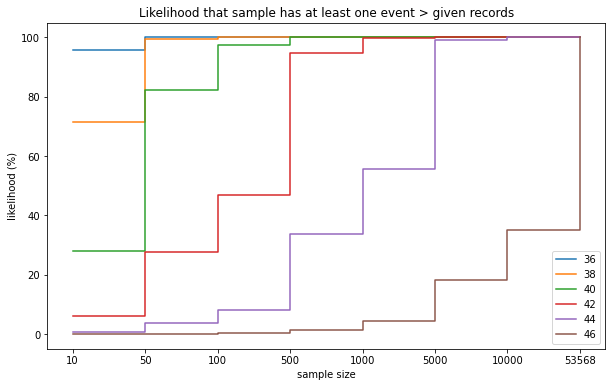

In [16]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot()

thresholds = [36, 38, 40, 42, 44, 46]
for threshold in thresholds:
    likelihoods, sample_sizes = likelihood_curve(threshold)
    ax.step(np.arange(len(sample_sizes)) + 1, likelihoods, where='post', label=threshold)
ax.set_xticklabels([0] + sample_sizes)
ax.set_ylabel('likelihood (%)')
ax.set_xlabel('sample size')
ax.set_title('Likelihood that sample has at least one event > given records')
ax.legend()
plt.savefig(f'/g/data/xv83/dbi599/tasmax_likelihoods_seatac.pdf', bbox_inches='tight', facecolor='white')
#plt.show()

In [11]:
population_size = 62 * 9 * 96
n_repeats = 100

df_ks_scores = pd.DataFrame([0]*n_repeats, columns=[population_size])
df_ks_pvals = pd.DataFrame([1]*n_repeats, columns=[population_size])

for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
    print(sample_size)
    scores = []
    pvals = []
    for resample in range(n_repeats):
        random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
        random_indexes.sort()
        sample_ds = ds_cafe_stacked['tasmax'].isel({'sample': random_indexes})
        ks_score, pval = xks.ks1d2s(sample_ds, ds_cafe_stacked['tasmax'], 'sample')
        scores.append(float(ks_score))
        pvals.append(float(pval)) 
    df_ks_scores[sample_size] = scores
    df_ks_pvals[sample_size] = pvals

df_ks_scores = df_ks_scores.reindex(sorted(df_ks_scores.columns), axis=1)    
df_ks_pvals = df_ks_pvals.reindex(sorted(df_ks_pvals.columns), axis=1)

10
50
100
500
1000
5000
10000


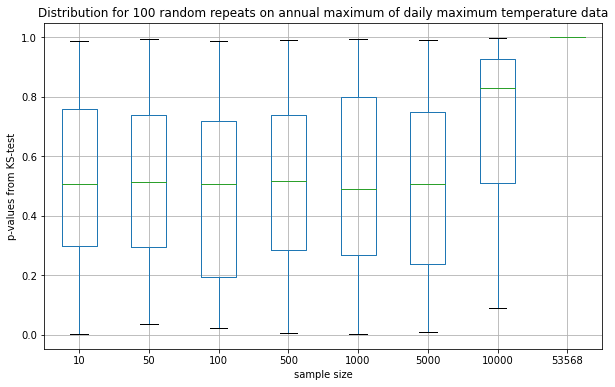

In [13]:
fig = plt.figure(figsize=[10, 6])
df_ks_pvals.boxplot()
plt.title('Distribution for 100 random repeats on annual maximum of daily maximum temperature data')
plt.xlabel('sample size')
plt.ylabel('p-values from KS-test')
plt.show()

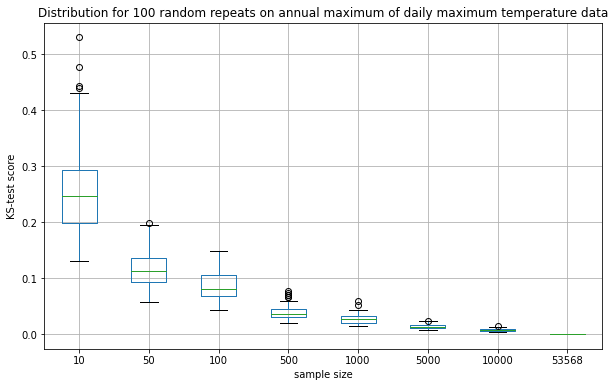

In [15]:
fig = plt.figure(figsize=[10, 6])
df_ks_scores.boxplot()
plt.title('Distribution for 100 random repeats on annual maximum of daily maximum temperature data')
plt.xlabel('sample size')
plt.ylabel('KS-test score')
plt.show()

In [14]:
xks.ks1d2s(ds_cafe_stacked['tasmax'].isel(sample=slice(0,100)), ds_cafe_stacked['tasmax'].isel(sample=slice(0,100)), 'sample')

(<xarray.DataArray 'tasmax' ()>
 array(0.),
 <xarray.DataArray 'tasmax' ()>
 array(1.))